# Import All The Neccessary Libraries For The Project

In [12]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from time import time
from PIL import ImageDraw
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc
from scipy import ndimage
# from scipy.ndimage.interpolation import zoom

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from tensorflow.keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# Function For Visualizing Training Results

In [22]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label1="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label1="Validation acc")
    ax[0].legend()
    ax[1].legend()

# Preprocessing

In [14]:
train_dir = '/Deep Learning/skrips/train'
val_dir = '/Deep Learning/skrips/valid'

In [15]:
augs = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True)  

train_gen = augs.flow_from_directory(
    train_dir,
    target_size = (128,128),
    batch_size=32,
    class_mode = 'binary',
    shuffle=True)

val_gen = augs.flow_from_directory(
    val_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary')

Found 15884 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# The Sequential Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 61, 61, 64)       

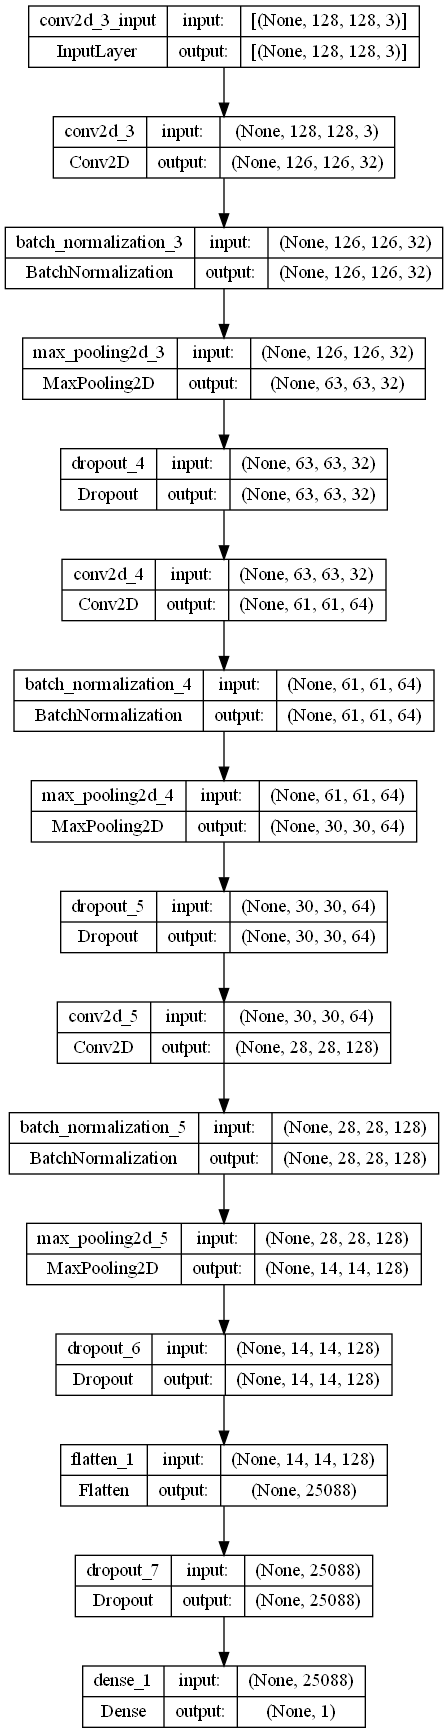

In [16]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Callbacks

In [17]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    verbose=1,
    save_freq='epoch',
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    # period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1,
    mode='auto'
)
# tensorboard = TensorBoard(
#     log_dir = './logs',
#     histogram_freq=0,
#     batch_size=16,
#     write_graph=True,
#     write_grads=True,
#     write_images=False,
# )

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,earlystop]

# Model Training

In [18]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
    
history = model.fit(
    train_gen, 
    steps_per_epoch  = 100, 
    validation_data  = val_gen,
    validation_steps = 100,
    epochs           = 30,
    verbose          = 1,
    validation_split = 0.1,
    callbacks=callbacks
)

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 1.3513 - accuracy: 0.6622WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 100 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_loss improved from inf to 1.62634, saving model to best_model.h5
100/100 [==============================] - 70s 683ms/step - loss: 1.3513 - accuracy: 0.6622 - val_loss: 1.6263 - val_accuracy: 0.5100
Epoch 2/30


c:\Users\Hani\.conda\envs\09040620070DATAMINING2023\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 58s 575ms/step - loss: 1.2872 - accuracy: 0.6931
Epoch 3/30
100/100 [==============================] - 60s 600ms/step - loss: 1.1667 - accuracy: 0.6866
Epoch 4/30
100/100 [==============================] - 65s 647ms/step - loss: 1.2148 - accuracy: 0.6891
Epoch 5/30
100/100 [==============================] - 56s 554ms/step - loss: 1.2731 - accuracy: 0.6928
Epoch 6/30
100/100 [==============================] - 55s 547ms/step - loss: 1.2945 - accuracy: 0.6784
Epoch 7/30
100/100 [==============================] - 57s 570ms/step - loss: 1.2164 - accuracy: 0.6875
Epoch 8/30
100/100 [==============================] - 57s 572ms/step - loss: 1.1548 - accuracy: 0.6962
Epoch 9/30
100/100 [==============================] - 57s 571ms/step - loss: 1.1391 - accuracy: 0.6891
Epoch 10/30
100/100 [==============================] - 56s 559ms/step - loss: 0.9829 - accuracy: 0.7166
Epoch 11/30
100/100 [==============================] - 59s 587ms/step - loss: 0.983

# Evaluate The Model And Save The Weights Of The Model

ValueError: x and y must have same first dimension, but have shapes (30,) and (1,)

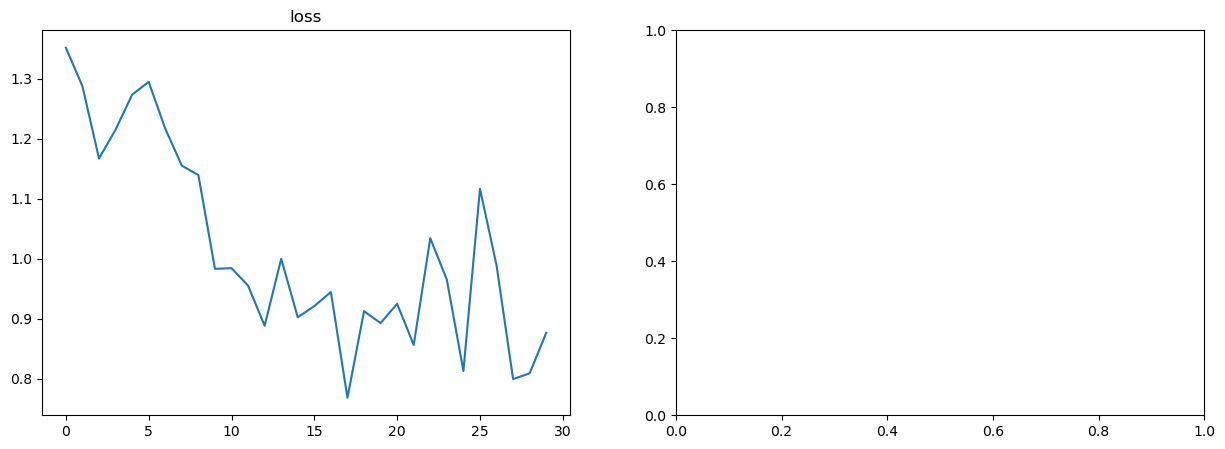

In [21]:
show_final_history(history)
model.load_weights('./base.model.h5')
model_score = model.evaluate_generator(val_gen,steps=100)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("trypophobia.h5")
print("Weights Saved")